In [1]:
import pandas as pd
import datetime
from random import randint
from time import sleep
import os
import requests
import json
import matplotlib.pyplot as plt
import numpy as np
import hvplot.pandas
import geopandas as gpd
import seaborn as sns
from scipy.stats import pearsonr, mannwhitneyu

In [2]:
# Get game dates of games played

url = "https://en.wikipedia.org/wiki/List_of_Stanley_Cup_champions"

stanleycup_champs = pd.read_html(url)

stanleycup_byyear_df = stanleycup_champs[2]
stanleycup_byyear_df.head()

Year                     Winning team                   Coach Games  \
0  1927     Ottawa Senators (C) (5, 4–1)               Dave Gill   2–0   
1  1928    New York Rangers (A) (1, 1–0)  Lester Patrick-playing   3–2   
2  1929       Boston Bruins (A) (2, 1–1)                Art Ross   2–0   
3  1930  Montreal Canadiens (C) (6, 3–2)              Cecil Hart   2–0   
4  1931  Montreal Canadiens (C) (7, 4–2)              Cecil Hart   3–2   

                        Losing team         Coach.1  \
0        Boston Bruins (A) (1, 0–1)        Art Ross   
1     Montreal Maroons (C) (2, 1–1)    Eddie Gerard   
2     New York Rangers (A) (2, 1–1)  Lester Patrick   
3        Boston Bruins (A) (3, 1–2)        Art Ross   
4  Chicago Black Hawks (A) (1, 0–1)      Dick Irvin   

                   Winning goal  
0     Cy Denneny (7:30, second)  
1   Frank Boucher (3:35, third)  
2    Bill Carson (18:02, third)  
3   Howie Morenz (1:00, second)  
4  Johnny Gagnon (9:59, second)

In [3]:
# Find Winning Teams from 1991-2002

stanleycup_winner_cleaned_df = stanleycup_byyear_df.loc[stanleycup_byyear_df['Year'].between(1992,2022)]
stanleycup_winner_cleaned_df = stanleycup_winner_cleaned_df[["Year", "Winning team"]]

stanleycup_winner_cleaned_df.reset_index(drop=True, inplace=True)

stanleycup_winner_cleaned_df["Year"] = (stanleycup_winner_cleaned_df["Year"] -1).map(str) + (stanleycup_winner_cleaned_df["Year"]).map(str)
stanleycup_winner_cleaned_df["Winning team"] = stanleycup_winner_cleaned_df["Winning team"].str.split('(').str[0]

stanleycup_winner_cleaned_df.drop(stanleycup_winner_cleaned_df[(stanleycup_winner_cleaned_df['Year'] == "20042005")].index, inplace=True)
stanleycup_winner_cleaned_df.rename(columns={"Winning team":"Team Name"}, inplace=True)
stanleycup_winner_cleaned_df["Team Name"] = stanleycup_winner_cleaned_df["Team Name"].str.strip()

# Change names 
stanleycup_winner_cleaned_df["Team Name"] = stanleycup_winner_cleaned_df["Team Name"].str.replace("Montreal Canadiens", "Montréal Canadiens")
stanleycup_winner_cleaned_df

Year            Team Name
0   19911992  Pittsburgh Penguins
1   19921993   Montréal Canadiens
2   19931994     New York Rangers
3   19941995    New Jersey Devils
4   19951996   Colorado Avalanche
5   19961997    Detroit Red Wings
6   19971998    Detroit Red Wings
7   19981999         Dallas Stars
8   19992000    New Jersey Devils
9   20002001   Colorado Avalanche
10  20012002    Detroit Red Wings
11  20022003    New Jersey Devils
12  20032004  Tampa Bay Lightning
14  20052006  Carolina Hurricanes
15  20062007        Anaheim Ducks
16  20072008    Detroit Red Wings
17  20082009  Pittsburgh Penguins
18  20092010   Chicago Blackhawks
19  20102011        Boston Bruins
20  20112012    Los Angeles Kings
21  20122013   Chicago Blackhawks
22  20132014    Los Angeles Kings
23  20142015   Chicago Blackhawks
24  20152016  Pittsburgh Penguins
25  20162017  Pittsburgh Penguins
26  20172018  Washington Capitals
27  20182019      St. Louis Blues
28  20192020  Tampa Bay Lightning
29  20202021  Tampa Bay Lightning
30  20212022   Colorado Avalanche

In [4]:
# Get Team Name and associated with its ID in the NHL API JSON request

teamID_url = "https://statsapi.web.nhl.com/api/v1/teams"
   
response = requests.get(teamID_url)

response_json = response.json()
team_info = {}

for team in response_json["teams"]:
    team_id = team["id"]
    team_name = team["name"]
    team_info[team_id] = team_name
   
team_info_df = pd.DataFrame.from_dict(team_info, orient="index", columns=["Team Name"])
team_info_df.reset_index(inplace=True)
team_info_df.columns = ["Team ID", "Team Name"]

team_info_df

Team ID              Team Name
0         1      New Jersey Devils
1         2     New York Islanders
2         3       New York Rangers
3         4    Philadelphia Flyers
4         5    Pittsburgh Penguins
5         6          Boston Bruins
6         7         Buffalo Sabres
7         8     Montréal Canadiens
8         9        Ottawa Senators
9        10    Toronto Maple Leafs
10       12    Carolina Hurricanes
11       13       Florida Panthers
12       14    Tampa Bay Lightning
13       15    Washington Capitals
14       16     Chicago Blackhawks
15       17      Detroit Red Wings
16       18    Nashville Predators
17       19        St. Louis Blues
18       20         Calgary Flames
19       21     Colorado Avalanche
20       22        Edmonton Oilers
21       23      Vancouver Canucks
22       24          Anaheim Ducks
23       25           Dallas Stars
24       26      Los Angeles Kings
25       28        San Jose Sharks
26       29  Columbus Blue Jackets
27       30         Minnesota Wild
28       52          Winnipeg Jets
29       53        Arizona Coyotes
30       54   Vegas Golden Knights
31       55         Seattle Kraken

In [5]:
# Merge dataframes to associate the Winning Team and Season won with the Team ID

stanleycup_winning_merge_byname_ID = pd.DataFrame.merge(stanleycup_winner_cleaned_df,team_info_df, on='Team Name', how='left')
stanleycup_winning_merge_byname_ID

Year            Team Name  Team ID
0   19911992  Pittsburgh Penguins        5
1   19921993   Montréal Canadiens        8
2   19931994     New York Rangers        3
3   19941995    New Jersey Devils        1
4   19951996   Colorado Avalanche       21
5   19961997    Detroit Red Wings       17
6   19971998    Detroit Red Wings       17
7   19981999         Dallas Stars       25
8   19992000    New Jersey Devils        1
9   20002001   Colorado Avalanche       21
10  20012002    Detroit Red Wings       17
11  20022003    New Jersey Devils        1
12  20032004  Tampa Bay Lightning       14
13  20052006  Carolina Hurricanes       12
14  20062007        Anaheim Ducks       24
15  20072008    Detroit Red Wings       17
16  20082009  Pittsburgh Penguins        5
17  20092010   Chicago Blackhawks       16
18  20102011        Boston Bruins        6
19  20112012    Los Angeles Kings       26
20  20122013   Chicago Blackhawks       16
21  20132014    Los Angeles Kings       26
22  20142015   Chicago Blackhawks       16
23  20152016  Pittsburgh Penguins        5
24  20162017  Pittsburgh Penguins        5
25  20172018  Washington Capitals       15
26  20182019      St. Louis Blues       19
27  20192020  Tampa Bay Lightning       14
28  20202021  Tampa Bay Lightning       14
29  20212022   Colorado Avalanche       21

In [6]:
# Get Roster for each Winning team per Season.  

player_list = []
base_url = "https://statsapi.web.nhl.com/api/v1/teams/{}?expand=team.roster&season={}"
for index, row in stanleycup_winning_merge_byname_ID.iterrows():
    team_ids = row ["Team ID"]
    # print(team_ids)
    year_cl= row ["Year"]
    # print(year_cl)
    url = base_url.format(team_ids, year_cl)
    # print(url)
    response = requests.get(url)
    data = response.json()
    
    for player in data["teams"][0]["roster"]["roster"]:
        
        person = player["person"]["fullName"]
        # Create dictionary
        player_id = player["person"]["id"]
        # Printing for testing purposes
        #print("Name:", person)
        #print("ID:", player_id)
        player_list.append({
            "Name":person,
            "Player ID":player_id,
            "Team ID": team_ids,
            "Season":year_cl
        })
winning_df=pd.DataFrame(player_list)
winning_df.head()
     

Name  Player ID  Team ID    Season
0   Phil Bourque    8445629        5  19911992
1   Jay Caufield    8446013        5  19911992
2  Jeff Chychrun    8446050        5  19911992
3    Paul Coffey    8446117        5  19911992
4   Jeff Daniels    8446305        5  19911992

In [7]:
   
# Player Profile - Winning Team per Season

base_url = "https://statsapi.web.nhl.com/api/v1/people/{}"
player_ages = []
player_nationalities = []

for index, row in winning_df.iterrows():
    player_id = row["Player ID"]
    url = base_url.format(player_id)
    response = requests.get(url)
    data = response.json()

    player_age = data['people'][0]['birthDate']
    player_nationality = data['people'][0]['nationality']
    player_birthyear_yyyy = player_age[:4]
    winning_season_yyyy = row["Season"][4:]

    winning_age = (int(winning_season_yyyy)) - (int(player_birthyear_yyyy))
    
    player_ages.append(winning_age)
    player_nationalities.append(player_nationality)

In [8]:
winning_df["Age"] = player_ages
winning_df["Nationality"] = player_nationalities
winning_df.head()

Name  Player ID  Team ID    Season  Age Nationality
0   Phil Bourque    8445629        5  19911992   30         USA
1   Jay Caufield    8446013        5  19911992   32         USA
2  Jeff Chychrun    8446050        5  19911992   26         CAN
3    Paul Coffey    8446117        5  19911992   31         CAN
4   Jeff Daniels    8446305        5  19911992   24         CAN

In [9]:
# Building Penalty In Minutes (PIM) for Winning DF

base_url = "https://statsapi.web.nhl.com/api/v1/people/{}/stats?stats=statsSingleSeason&season={}" 
pim=[]

for index, row in winning_df.iterrows():
    player_id = row["Player ID"]
    year = row["Season"]
    url = base_url.format(player_id,year)
    response = requests.get(url)
    data = response.json()
    try:
        pim_data = data["stats"][0]["splits"][0]['stat']['pim']
        print(pim_data)
        pim.append(pim_data)
        
    except:
        print("not found")
        pim.append(0)    
        pass

58
175
111
87
0
0
119
30
16
34
104
8
94
127
30
48
36
4
96
87
110
206
62
254
57
151
54
0
2
0
not found
not found
not found
not found
not found
not found
not found
44
19
79
20
57
98
98
63
32
193
117
95
33
20
24
77
205
146
142
90
91
65
4
2
2
14
54
2
20
0
10
not found
not found
not found
62
170
8
62
29
127
70
47
129
139
41
67
33
70
91
57
76
69
28
40
114
17
110
37
2
7
58
0
0
36
39
154
6
2
not found
not found
20
24
19
16
12
14
54
18
2
18
86
44
32
36
167
10
56
4
0
0
72
13
17
0
25
27
6
18
17
0
8
not found
not found
56
32
46
4
20
49
117
73
22
146
52
147
44
50
50
88
85
20
49
0
250
14
47
68
33
54
14
2
30
142
6
6
0
not found
not found
not found
8
73
47
30
76
218
70
26
20
0
58
69
131
78
26
151
46
30
5
52
52
167
129
0
126
75
10
28
33
not found
not found
not found
12
45
25
72
40
92
40
65
37
57
154
46
46
18
47
106
81
16
119
157
89
32
6
43
44
0
not found
not found
not found
54
31
18
26
30
62
34
10
87
44
34
16
50
33
133
102
16
50
20
51
0
85
10
18
62
23
19
0
2
16
12
10
not found
not found
not found
98
10

In [10]:
# Building Power Play Goals for Winning DF

base_url = "https://statsapi.web.nhl.com/api/v1/people/{}/stats?stats=statsSingleSeason&season={}" 
power_play_goal=[]

for index, row in winning_df.iterrows():
    player_id = row["Player ID"]
    year = row["Season"]
    url = base_url.format(player_id,year)
    response = requests.get(url)
    data = response.json()
    try:
        ppg_data = data["stats"][0]["splits"][0]['stat']['powerPlayGoals']
        print(ppg_data)
        power_play_goal.append(ppg_data)
        
    except:
        print("not found")
        power_play_goal.append(0)    
        pass

0
0
0
5
0
0
0
5
0
4
0
1
12
0
14
7
0
0
20
1
0
1
0
19
0
8
3
0
0
0
not found
not found
not found
not found
not found
not found
not found
16
0
4
0
0
9
7
6
0
0
6
0
2
8
1
12
0
5
0
4
3
0
0
0
0
0
1
0
0
0
0
not found
not found
not found
7
1
0
11
1
20
0
0
0
0
6
17
0
0
1
3
6
10
0
5
5
0
0
4
0
0
1
0
0
4
9
7
0
0
not found
not found
2
2
0
0
2
1
0
1
3
0
1
0
2
1
0
1
1
0
1
0
4
0
0
0
0
0
0
4
2
0
0
not found
not found
0
1
0
0
0
2
9
0
0
16
3
0
17
0
7
1
18
0
6
0
4
3
7
9
0
8
1
0
0
3
0
0
0
not found
not found
not found
1
1
0
9
0
0
0
2
5
0
0
1
20
8
1
0
3
8
0
0
0
5
0
0
5
0
0
0
3
not found
not found
not found
6
1
2
0
5
0
3
0
2
0
15
6
6
7
0
4
0
0
3
5
2
1
0
0
1
0
not found
not found
not found
2
0
1
2
15
1
0
0
0
6
8
1
0
0
8
3
1
9
5
1
0
2
0
7
4
0
0
0
0
0
0
0
not found
not found
not found
0
7
7
3
5
1
0
0
0
1
0
1
5
1
7
0
0
2
1
0
5
1
0
9
0
0
0
0
0
7
1
not found
not found
not found
10
2
0
0
19
1
2
0
0
12
0
7
0
0
0
0
0
11
12
0
0
0
0
0
1
0
2
7
3
3
not found
not found
not found
not found
1
0
1
10
0
7
0
4
0
13
12
5
6
1
0
0


In [11]:
# Building Over Time Goal for Winning DF

base_url = "https://statsapi.web.nhl.com/api/v1/people/{}/stats?stats=statsSingleSeason&season={}" 
over_time_goal=[]

for index, row in winning_df.iterrows():
    player_id = row["Player ID"]
    year = row["Season"]
    url = base_url.format(player_id,year)
    response = requests.get(url)
    data = response.json()
    try:
        otg_data = data["stats"][0]["splits"][0]['stat']['overTimeGoals']
        print(otg_data)
        over_time_goal.append(otg_data)
        
    except:
        print("not found")
        over_time_goal.append(0)    
        pass

1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
not found
not found
not found
not found
not found
not found
not found
1
0
0
0
0
2
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
1
not found
not found
not found
1
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
not found
not found
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
not found
not found
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
not found
not found
not found
0
0
0
1
0
0
0
1
1
0
0
1
1
0
0
0
1
0
0
0
0
0
0
0
1
0
0
0
0
not found
not found
not found
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
not found
not found
not found
1
0
0
0
1
0
0
0
0
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
not found
not found
not found
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
1
0
0
0
0
0
1
0
0
0
0
0
0
0
not found
not found
not found
0
0
0
0
2
0
0
0
0
2
0
0
0
0
0
0
0
0
2
0
0
0
0
0
0
0
0
0
0
0
not found
not found
not found
not found
1
1
0
1
0
2
0
0
0
1
2
1
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
no

In [12]:
# Building Plus Minus (+/-) for Winning DF

base_url = "https://statsapi.web.nhl.com/api/v1/people/{}/stats?stats=statsSingleSeason&season={}" 
plus_mins=[]

for index, row in winning_df.iterrows():
    player_id = row["Player ID"]
    year = row["Season"]
    url = base_url.format(player_id,year)
    response = requests.get(url)
    data = response.json()
    try:
        pm_data = data["stats"][0]["splits"][0]['stat']['plusMinus']
        print(pm_data)
        plus_mins.append(pm_data)
        
    except:
        print("not found")
        plus_mins.append(0)    
        pass

-6
-6
-12
1
0
-2
1
-7
4
12
-1
-2
27
-5
12
33
0
5
-21
19
1
2
-8
8
7
15
-11
1
-1
0
not found
not found
not found
not found
not found
not found
not found
4
13
6
-9
25
5
20
5
0
6
7
29
11
23
14
8
35
-24
2
1
8
4
1
-4
0
11
-5
-3
6
-1
2
not found
not found
not found
-5
18
-4
20
-3
27
-5
-5
-9
-16
14
28
-12
4
-14
15
25
7
-1
-5
5
-13
4
0
-8
1
12
0
-1
13
20
18
0
-2
not found
not found
9
1
-1
-4
2
-1
4
-1
1
9
2
10
13
6
5
8
4
6
-5
-2
6
-5
4
-1
-7
-1
3
19
5
-3
12
not found
not found
29
3
-5
4
1
26
14
32
15
-33
1
6
14
25
2
27
14
12
20
0
10
7
26
18
10
2
-1
1
15
20
3
-2
1
not found
not found
not found
-3
-11
-5
29
26
-8
-7
31
3
0
8
6
32
22
-18
38
21
11
0
-6
-9
-14
1
-1
14
3
5
-10
-10
not found
not found
not found
17
5
10
4
4
7
14
-17
35
-9
6
3
14
22
-1
0
3
2
-7
0
11
21
1
5
6
0
not found
not found
not found
-10
-3
6
2
19
-2
-5
0
5
29
11
0
-2
2
11
21
4
-1
9
23
0
1
-1
29
10
-2
3
-3
0
-3
1
-1
not found
not found
not found
13
7
-3
8
3
-9
30
2
-6
1
1
19
-12
0
22
-6
0
12
-2
-6
24
-13
-2
16
1
0
3
1
7
14
21
not

In [13]:
# Building Points for Winning DF

base_url = "https://statsapi.web.nhl.com/api/v1/people/{}/stats?stats=statsSingleSeason&season={}" 
points=[]

for index, row in winning_df.iterrows():
    player_id = row["Player ID"]
    year = row["Season"]
    url = base_url.format(player_id,year)
    response = requests.get(url)
    data = response.json()
    try:
        points_data = data["stats"][0]["splits"][0]['stat']['points']
        print(points_data)
        points.append(points_data)
        
    except:
        print("not found")
        points.append(0)    
        pass

26
0
4
69
0
0
35
54
16
69
9
9
131
26
87
77
8
10
97
24
16
15
10
123
4
59
29
4
0
0
not found
not found
not found
not found
not found
not found
not found
88
25
31
17
18
97
45
48
3
14
25
60
44
80
32
94
16
18
8
50
44
14
6
0
0
17
8
0
12
0
3
not found
not found
not found
41
16
6
64
15
79
2
11
3
8
60
79
2
19
32
38
84
41
8
35
54
19
9
42
4
0
18
0
2
49
89
56
2
1
not found
not found
15
32
16
18
21
9
3
16
15
20
19
12
29
23
11
39
22
1
5
1
25
2
3
0
18
0
3
19
18
0
14
not found
not found
20
17
27
3
9
16
71
19
21
69
27
8
120
27
60
16
85
15
56
0
34
20
116
75
9
54
3
2
27
48
1
1
1
not found
not found
not found
13
13
12
63
28
4
3
54
45
0
13
42
88
85
32
38
45
57
0
7
7
33
11
1
49
8
6
12
9
not found
not found
not found
42
23
17
14
27
11
47
7
52
12
57
69
52
59
10
34
9
13
43
37
23
21
2
17
22
0
not found
not found
not found
29
16
11
27
58
29
1
0
8
81
55
17
3
5
34
30
20
48
51
12
0
31
0
52
45
0
3
0
0
8
1
0
not found
not found
not found
6
46
47
39
44
24
29
2
4
5
26
38
31
20
56
11
15
35
16
0
68
10
11
72
11
0
3
0
25
7

In [14]:
winning_df['PIM'] = pim 
winning_df['PPG'] = power_play_goal
winning_df['OTG'] = over_time_goal
winning_df['+/-'] = plus_mins
winning_df['Pts'] = points
winning_df.head()

Name  Player ID  Team ID    Season  Age Nationality  PIM  PPG  \
0   Phil Bourque    8445629        5  19911992   30         USA   58    0   
1   Jay Caufield    8446013        5  19911992   32         USA  175    0   
2  Jeff Chychrun    8446050        5  19911992   26         CAN  111    0   
3    Paul Coffey    8446117        5  19911992   31         CAN   87    5   
4   Jeff Daniels    8446305        5  19911992   24         CAN    0    0   

   OTG  +/-  Pts  
0    1   -6   26  
1    0   -6    0  
2    0  -12    4  
3    0    1   69  
4    0    0    0

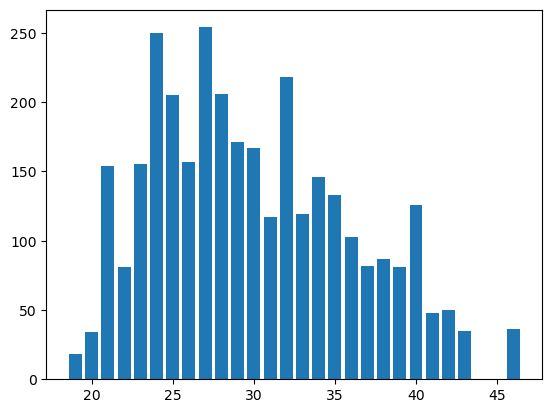

In [56]:
age_vs_pim = plt.bar(winning_df["Age"],winning_df["PIM"])#,edgecolors='black',marker='o',alpha=0.75,s=30)

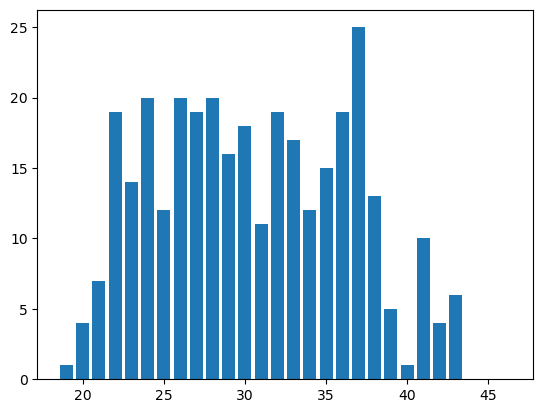

In [57]:
age_vs_ppg = plt.bar(winning_df["Age"],winning_df["PPG"])#,edgecolors='black',marker='o',alpha=0.75,s=30)

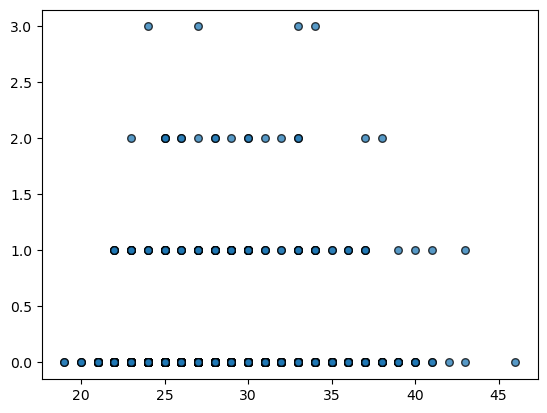

In [18]:
age_vs_otg = plt.scatter(winning_df["Age"],winning_df["OTG"],edgecolors='black',marker='o',alpha=0.75,s=30)

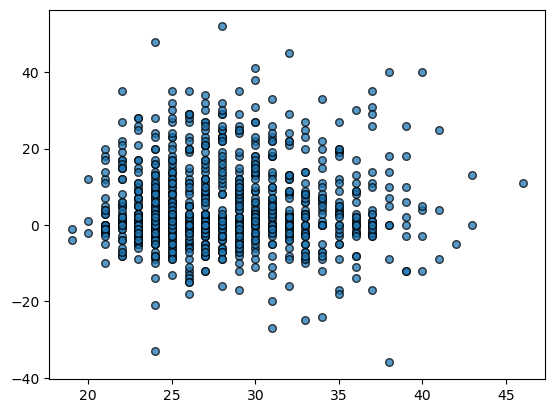

In [19]:
age_vs_p_m = plt.scatter(winning_df["Age"],winning_df["+/-"],edgecolors='black',marker='o',alpha=0.75,s=30)

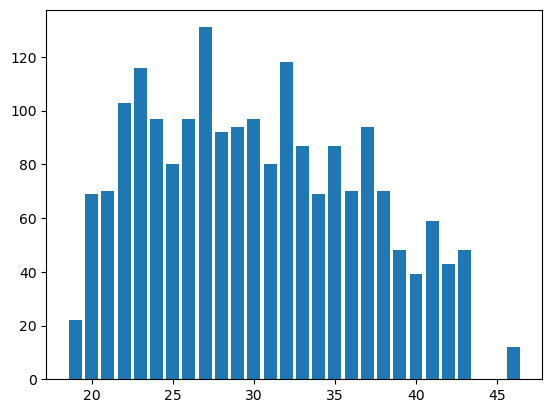

In [30]:
age_vs_pts = plt.bar(winning_df["Age"],winning_df["Pts"])

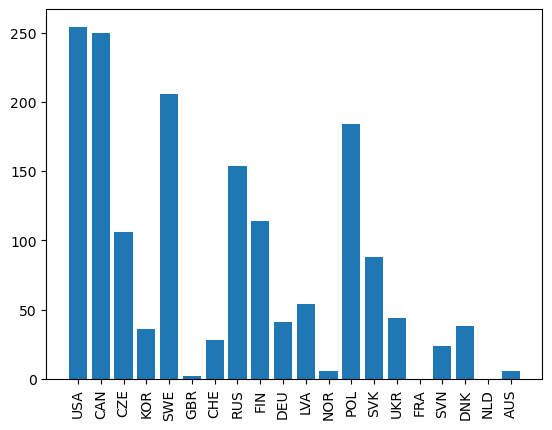

In [29]:
nat_vs_pim = plt.bar(winning_df["Nationality"],winning_df["PIM"])
plt.xticks(rotation ="vertical")
plt.show()

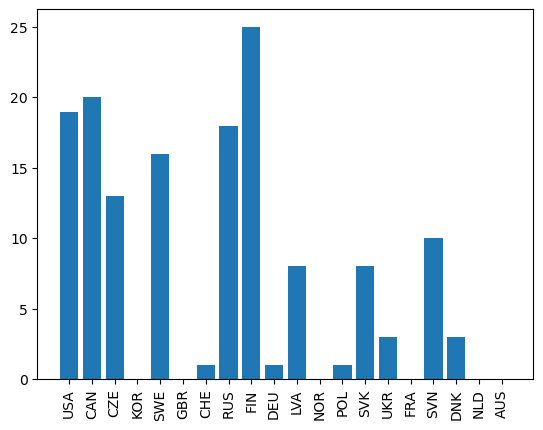

In [28]:
nat_vs_ppg = plt.bar(winning_df["Nationality"],winning_df["PPG"])
plt.xticks(rotation ="vertical")
plt.show()

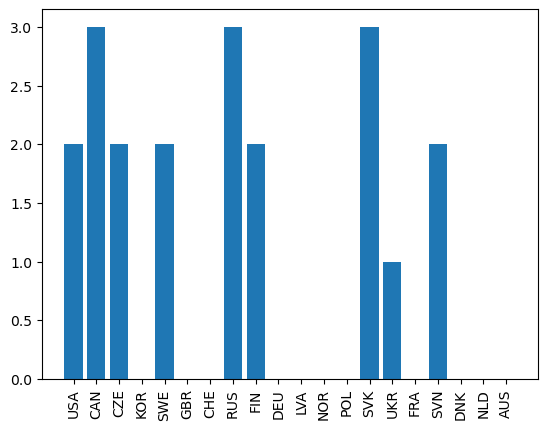

In [31]:
nat_vs_otg = plt.bar(winning_df["Nationality"],winning_df["OTG"])
plt.xticks(rotation ="vertical")
plt.show()

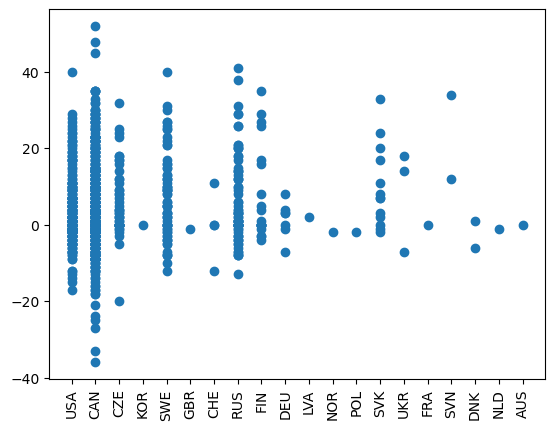

In [33]:
nat_vs_p_m = plt.scatter(winning_df["Nationality"],winning_df["+/-"])
plt.xticks(rotation ="vertical")
plt.show()

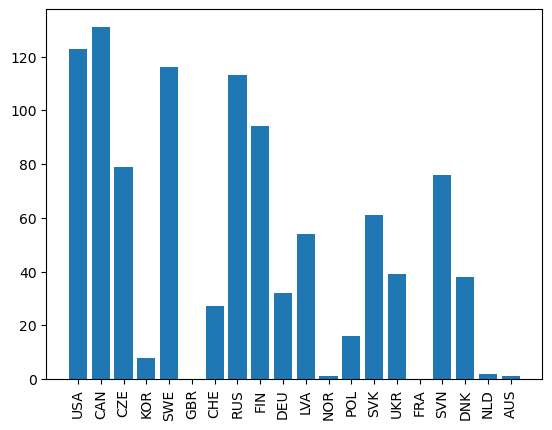

In [34]:
nat_vs_pts = plt.bar(winning_df["Nationality"],winning_df["Pts"])
plt.xticks(rotation ="vertical")
plt.show()

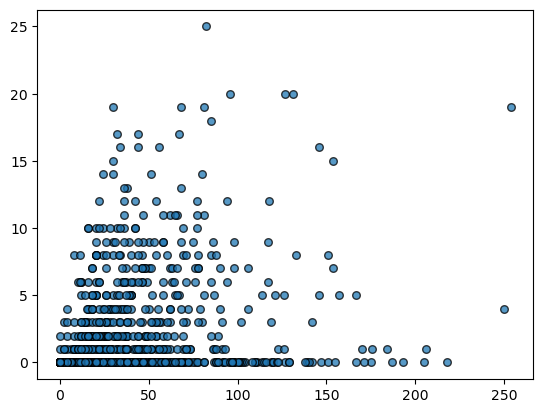

In [37]:
pim_vs_ppg = plt.scatter(winning_df["PIM"],winning_df["PPG"],edgecolors='black',marker='o',alpha=0.75,s=30)

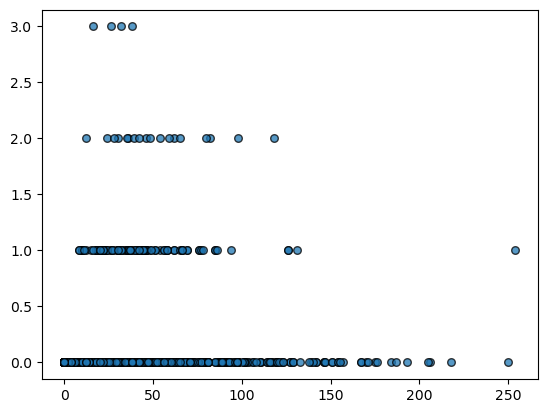

In [38]:
pim_vs_otg = plt.scatter(winning_df["PIM"],winning_df["OTG"],edgecolors='black',marker='o',alpha=0.75,s=30)

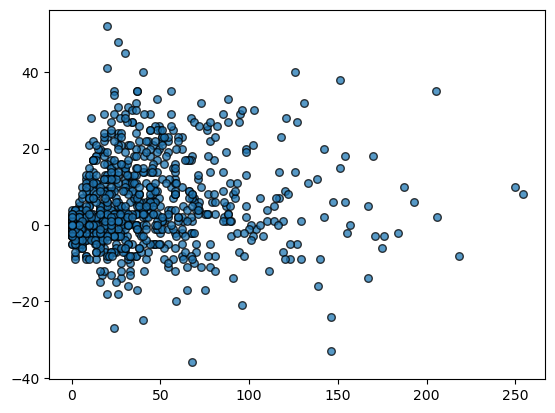

In [39]:
pim_vs_p_m = plt.scatter(winning_df["PIM"],winning_df["+/-"],edgecolors='black',marker='o',alpha=0.75,s=30)

The correlation between mouse weight and the average tumor volume is 0.16


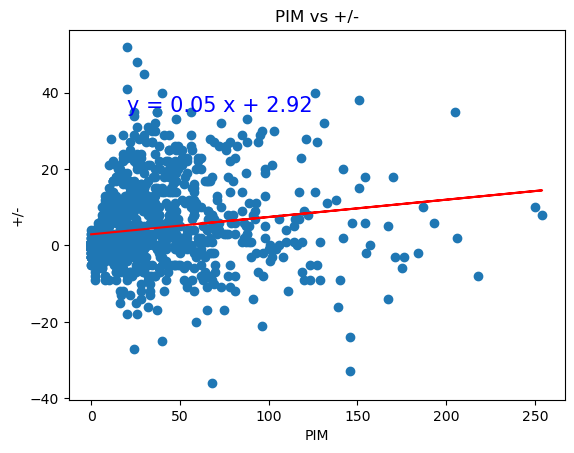

In [59]:
import scipy.stats as st
correlation_co = st.pearsonr(winning_df["PIM"],winning_df["+/-"])
#Print the correaltion anser
print(f"The correlation  is {round(correlation_co[0],2)}")
#Calculate linear regression
(slope, intercept,rvalue, pvalue, stderr)=st.linregress(winning_df["PIM"],winning_df["+/-"])
regress_values=winning_df["PIM"]* slope + intercept
line_eq= f"y = {round(slope, 2)} x + {round(intercept, 2)}"
plt.scatter(winning_df["PIM"],winning_df["+/-"],color='tab:blue')
plt.plot(winning_df["PIM"], regress_values, color='red')
plt.annotate(line_eq,(20,35), fontsize=15, color = "blue")
plt.xlabel("PIM")
plt.ylabel("+/-")
plt.title("PIM vs +/-")
plt.show()

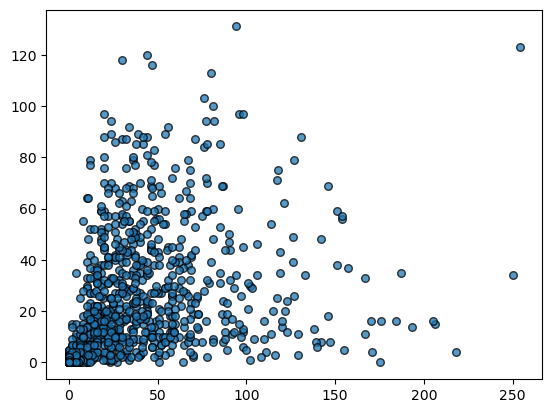

In [42]:
age_vs_pim = plt.scatter(winning_df["PIM"],winning_df["Pts"],edgecolors='black',marker='o',alpha=0.75,s=30)

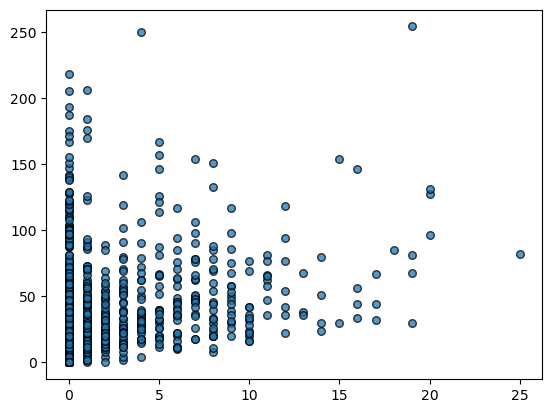

In [43]:
age_vs_pim = plt.scatter(winning_df["PPG"],winning_df["PIM"],edgecolors='black',marker='o',alpha=0.75,s=30)

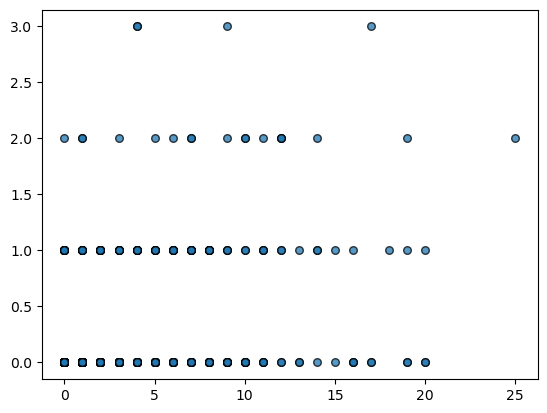

In [44]:
age_vs_pim = plt.scatter(winning_df["PPG"],winning_df["OTG"],edgecolors='black',marker='o',alpha=0.75,s=30)

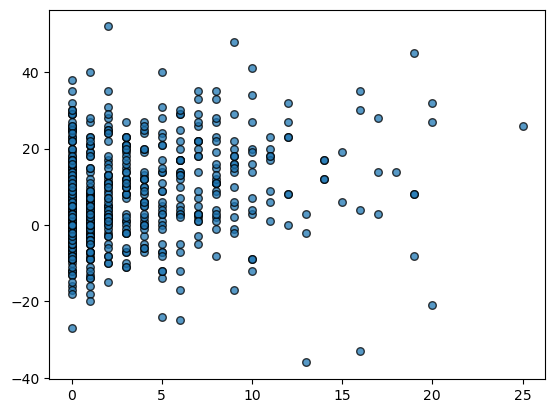

In [45]:
age_vs_pim = plt.scatter(winning_df["PPG"],winning_df["+/-"],edgecolors='black',marker='o',alpha=0.75,s=30)

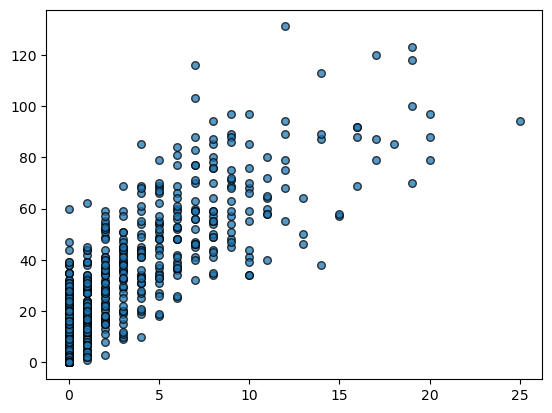

In [46]:
ppg_vs_pts = plt.scatter(winning_df["PPG"],winning_df["Pts"],edgecolors='black',marker='o',alpha=0.75,s=30)

The correlation between mouse weight and the average tumor volume is 0.83


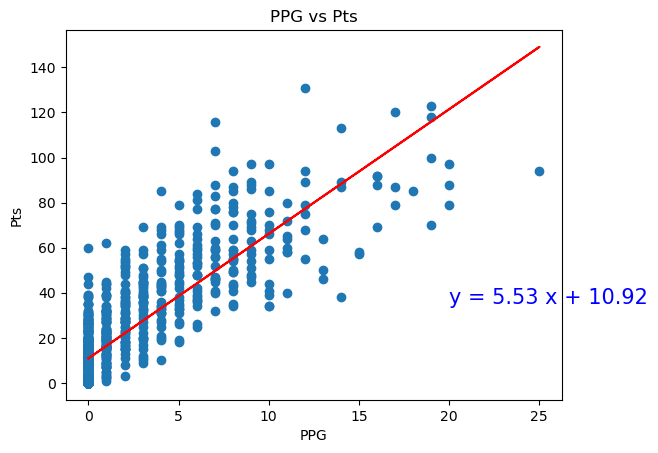

In [60]:
import scipy.stats as st
correlation_co = st.pearsonr(winning_df["PPG"],winning_df["Pts"])
#Print the correaltion anser
print(f"The correlation is {round(correlation_co[0],2)}")
#Calculate linear regression
(slope, intercept,rvalue, pvalue, stderr)=st.linregress(winning_df["PPG"],winning_df["Pts"])
regress_values=winning_df["PPG"]* slope + intercept
line_eq= f"y = {round(slope, 2)} x + {round(intercept, 2)}"
plt.scatter(winning_df["PPG"],winning_df["Pts"],color='tab:blue')
plt.plot(winning_df["PPG"], regress_values, color='red')
plt.annotate(line_eq,(20,35), fontsize=15, color = "blue")
plt.xlabel("PPG")
plt.ylabel("Pts")
plt.title("PPG vs Pts")
plt.show()

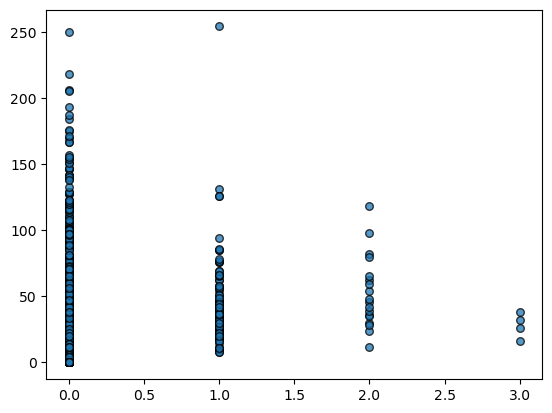

In [47]:
age_vs_pim = plt.scatter(winning_df["OTG"],winning_df["PIM"],edgecolors='black',marker='o',alpha=0.75,s=30)

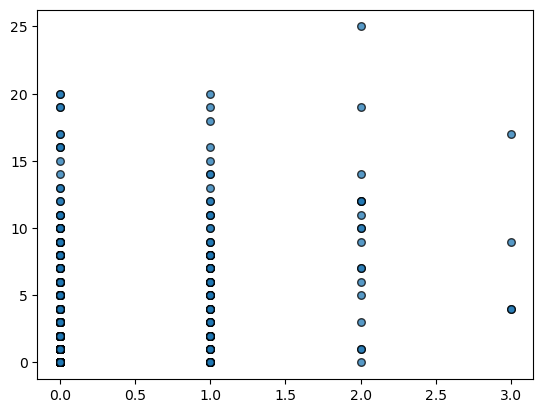

In [48]:
age_vs_pim = plt.scatter(winning_df["OTG"],winning_df["PPG"],edgecolors='black',marker='o',alpha=0.75,s=30)

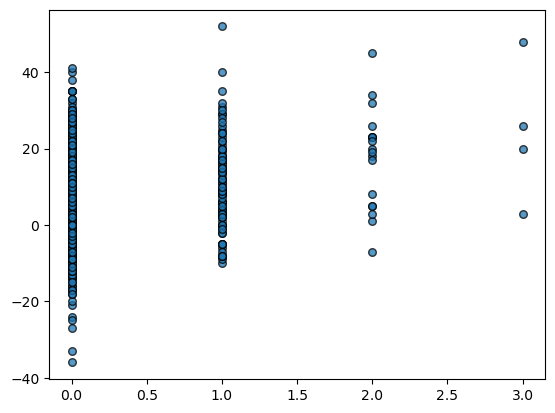

In [49]:
age_vs_pim = plt.scatter(winning_df["OTG"],winning_df["+/-"],edgecolors='black',marker='o',alpha=0.75,s=30)

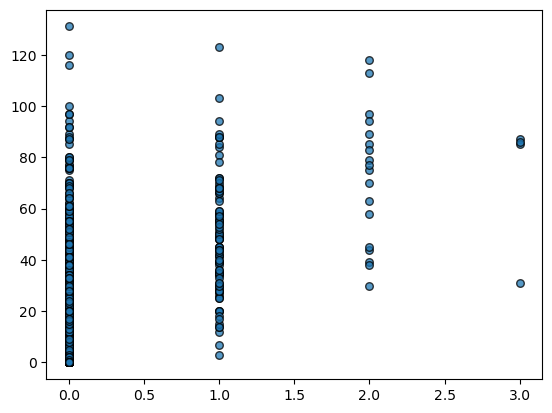

In [50]:
age_vs_pim = plt.scatter(winning_df["OTG"],winning_df["Pts"],edgecolors='black',marker='o',alpha=0.75,s=30)

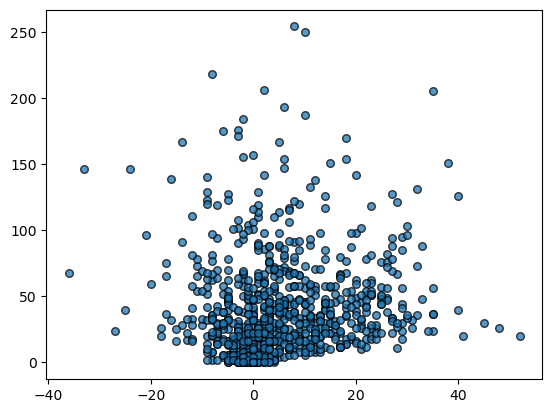

In [51]:
age_vs_pim = plt.scatter(winning_df["+/-"],winning_df["PIM"],edgecolors='black',marker='o',alpha=0.75,s=30)

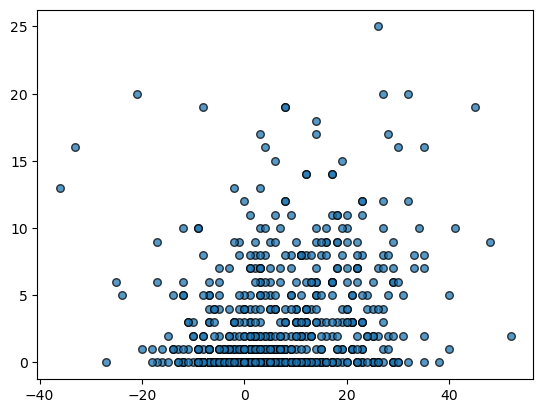

In [52]:
age_vs_pim = plt.scatter(winning_df["+/-"],winning_df["PPG"],edgecolors='black',marker='o',alpha=0.75,s=30)

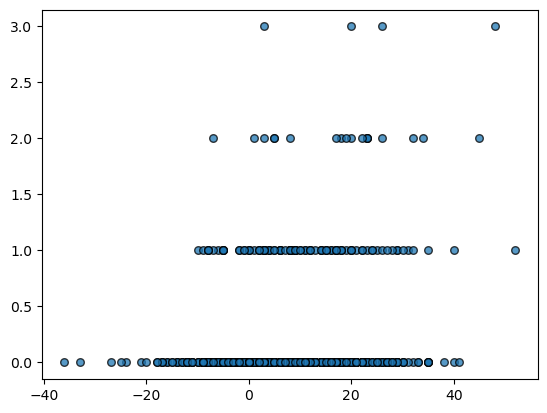

In [53]:
age_vs_pim = plt.scatter(winning_df["+/-"],winning_df["OTG"],edgecolors='black',marker='o',alpha=0.75,s=30)

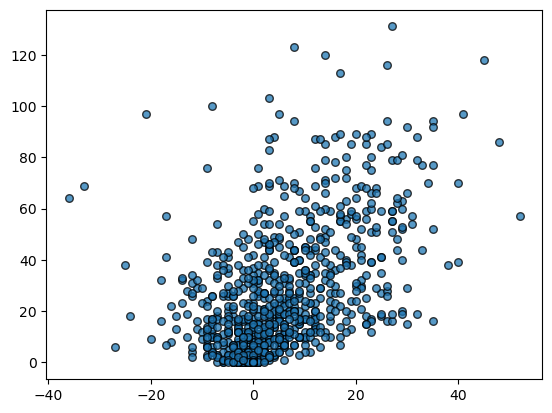

In [54]:
age_vs_pim = plt.scatter(winning_df["+/-"],winning_df["Pts"],edgecolors='black',marker='o',alpha=0.75,s=30)

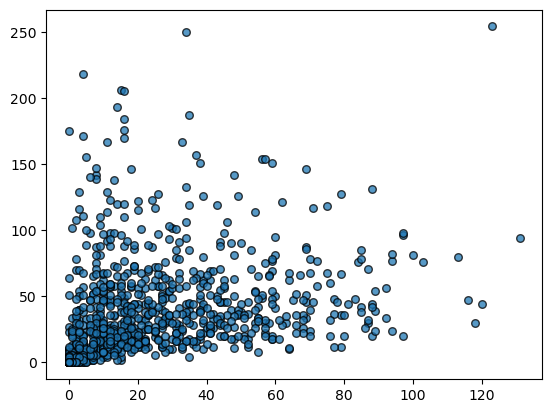

In [55]:
age_vs_pim = plt.scatter(winning_df["Pts"],winning_df["PIM"],edgecolors='black',marker='o',alpha=0.75,s=30)